In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [3]:
pip install pathlib2

In [4]:
import pickle as pk
import pandas as pd
from pathlib2 import Path
import numpy as np
import os

def pk_read(path):
    with open(path, 'rb') as f:
        D = pk.load(f,encoding='utf8')
    return D

def pk_dump(fn, D):
    with open(fn, 'wb') as f:
        pk.dump(D, f, protocol=pk.HIGHEST_PROTOCOL)
    return 'Dumped Successfully!'

In [5]:
df_train=pk_read('/content/drive/MyDrive/Deep Learning for Prediction/Final Project/Zixin_secret/result/lc_loan_processed_binary.pk')

In [6]:
df_train.shape

(878916, 42)

In [7]:
df_test=pk_read('/content/drive/MyDrive/Deep Learning for Prediction/Final Project/Zixin_secret/result/lc_2016_2017_processed_binary.pk')

In [8]:
df_test.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,delinq,derog,purpose,term,home_ownership,verification_status,recovery,pymnt_received,loan_status
0,2300,2300,2300.0,12.62,77.08,2,10,0.0,10000.0,21.61,0,1985,1.0,4,0,3911.0,55.1,6,0,2029.91,2029.91,382.99,382.99,270.09,112.90,0.0,77.08,0,0,0,0.0,3911.0,7100.0,0.0,0.0,1,36,2,0,0,1.0,0
1,16000,16000,16000.0,12.62,360.95,2,10,11.0,94000.0,25.61,0,1992,0.0,9,0,33752.0,105.8,26,0,14813.07,14813.07,2060.09,2060.09,1186.93,873.16,0.0,360.95,0,0,0,0.0,234457.0,31900.0,0.0,0.0,2,60,0,0,0,1.0,0
2,6025,6025,6025.0,15.05,209.01,2,13,8.0,46350.0,8.88,0,2002,0.0,11,0,12425.0,44.9,27,0,5340.82,5340.82,1032.46,1032.46,684.18,348.28,0.0,209.01,0,0,0,0.0,121311.0,27700.0,0.0,0.0,3,36,0,0,0,1.0,0
3,20400,20400,20400.0,9.44,652.91,1,5,11.0,44000.0,27.06,0,2007,1.0,15,0,8769.0,18.7,19,0,17898.81,17898.81,3237.80,3237.80,2501.19,736.61,0.0,652.91,0,0,0,0.0,62335.0,46900.0,0.0,0.0,0,36,3,1,0,1.0,0
4,13000,13000,13000.0,11.99,431.73,1,9,11.0,85000.0,6.79,1,2002,0.0,5,0,6866.0,88.0,24,0,11460.66,11460.66,2137.00,2137.00,1539.34,597.66,0.0,431.73,0,0,0,0.0,15332.0,7800.0,1.0,1.0,2,36,0,1,0,1.0,0


Q: what's the dim of the z_mean; z_log_sigma\
Q: how to control the number of layer of the hidden layers;\
Q: neutro number and dim
Q:how to evaluate autoencoder? (what's the meaning of mse here)


## 1 prepare data 

In [9]:
import keras
from keras import layers
from keras import models

{'0':'good', '1':'default'}

In [10]:
normal_events_train=df_train[df_train['loan_status'] == 0]
abnormal_events_train=df_train[df_train['loan_status'] == 1]
normal_events_train=normal_events_train.loc[:, normal_events_train.columns != 'loan_status']
abnormal_events_train=abnormal_events_train.loc[:, abnormal_events_train.columns != 'loan_status']

In [11]:
normal_events_test=df_test[df_test['loan_status'] == 0]
abnormal_events_test=df_test[df_test['loan_status'] == 1]
normal_events_test=normal_events_test.loc[:, normal_events_test.columns != 'loan_status']
abnormal_events_test=abnormal_events_test.loc[:, abnormal_events_test.columns != 'loan_status']

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758834 entries, 0 to 759337
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   758834 non-null  int64  
 1   funded_amnt                 758834 non-null  int64  
 2   funded_amnt_inv             758834 non-null  float64
 3   int_rate                    758834 non-null  float64
 4   installment                 758834 non-null  float64
 5   grade                       758834 non-null  int64  
 6   sub_grade                   758834 non-null  int64  
 7   emp_length                  758834 non-null  float64
 8   annual_inc                  758834 non-null  float64
 9   dti                         758834 non-null  float64
 10  delinq_2yrs                 758834 non-null  int64  
 11  earliest_cr_line            758834 non-null  int64  
 12  inq_last_6mths              758834 non-null  float64
 13  open_acc      

In [13]:
# scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_train.drop('loan_status', 1))
scaled_normal_train=scaler.transform(normal_events_train)
scaled_normal_test=scaler.transform(normal_events_test) #without y
scaled_abnormal_test=scaler.transform(abnormal_events_test)
scaled_df_test=scaler.transform(df_test.drop('loan_status', 1))


In [14]:
from sklearn.model_selection import train_test_split
scaled_normal_train, scaled_normal_validation=train_test_split(scaled_normal_train,train_size=0.9)

In [15]:
print(scaled_normal_train.shape,scaled_normal_validation.shape)

(738087, 41) (82010, 41)


## 2 Autoencoder

### Vesrion 1 'sigmoid', 'mse'

In [16]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation='relu', input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=10, activation='relu'))
encoder.add(layer=layers.Dense(units=5, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation='relu', input_shape=[5]))
decoder.add(layer=layers.Dense(units=20, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                840       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
Total params: 1,105
Trainable params: 1,105
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_10 (Dense)             (None, 20)                220       
________________________________________

In [17]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(x=scaled_normal_train, y=scaled_normal_train, epochs=100, verbose=1, validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])


Epoch 1/100
23066/23066 [==============================] - 36s 2ms/step - loss: 0.0233 - accuracy: 0.1502 - val_loss: 0.0109 - val_accuracy: 0.5554
Epoch 2/100
23066/23066 [==============================] - 36s 2ms/step - loss: 0.0106 - accuracy: 0.5658 - val_loss: 0.0095 - val_accuracy: 0.5777
Epoch 3/100
23066/23066 [==============================] - 35s 2ms/step - loss: 0.0091 - accuracy: 0.5798 - val_loss: 0.0077 - val_accuracy: 0.5818
Epoch 4/100
23066/23066 [==============================] - 35s 2ms/step - loss: 0.0073 - accuracy: 0.5682 - val_loss: 0.0068 - val_accuracy: 0.5692
Epoch 5/100
23066/23066 [==============================] - 35s 2ms/step - loss: 0.0066 - accuracy: 0.5723 - val_loss: 0.0064 - val_accuracy: 0.5819
Epoch 6/100
23066/23066 [==============================] - 35s 2ms/step - loss: 0.0064 - accuracy: 0.5815 - val_loss: 0.0064 - val_accuracy: 0.5907
Epoch 7/100
23066/23066 [==============================] - 35s 2ms/step - loss: 0.0062 - accuracy: 0.5908 - val_

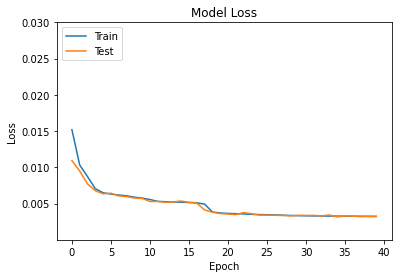

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.03,ymin=0.00001)
plt.show()

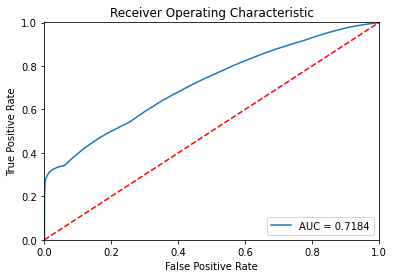

In [19]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

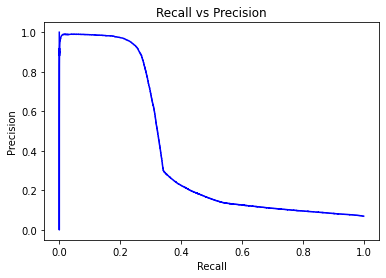

In [20]:
precision, recall, th = precision_recall_curve(error_df.loan_status, error_df.recon_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

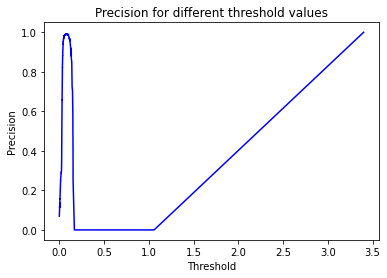

In [21]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [22]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

In [23]:
cut_off

0.009317588713020084

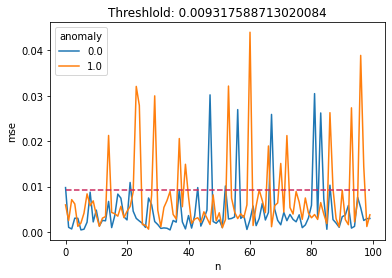

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

### version 2: sigmoid, mse, validation, more complex

In [15]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=64, activation='relu', input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=5, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[5]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 5)                 4933      
_________________________________________________________________
decoder (Sequential)         (None, 41)                4969      
Total params: 9,902
Trainable params: 9,902
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train, epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 43s 2ms/step - loss: 0.0118 - accuracy: 0.2676 - val_loss: 0.0038 - val_accuracy: 0.4821
Epoch 2/100
23066/23066 [==============================] - 42s 2ms/step - loss: 0.0035 - accuracy: 0.5027 - val_loss: 0.0031 - val_accuracy: 0.5068
Epoch 3/100
23066/23066 [==============================] - 41s 2ms/step - loss: 0.0026 - accuracy: 0.4992 - val_loss: 0.0018 - val_accuracy: 0.4601
Epoch 4/100
23066/23066 [==============================] - 38s 2ms/step - loss: 0.0017 - accuracy: 0.4551 - val_loss: 0.0016 - val_accuracy: 0.4817
Epoch 5/100
23066/23066 [==============================] - 39s 2ms/step - loss: 0.0016 - accuracy: 0.4858 - val_loss: 0.0015 - val_accuracy: 0.5179
Epoch 6/100
23066/23066 [==============================] - 40s 2ms/step - loss: 0.0015 - accuracy: 0.4963 - val_loss: 0.0015 - val_accuracy: 0.5132
Epoch 7/100
23066/23066 [==============================] - 44s 2ms/step - loss: 0.0015 - accuracy: 0.5036 - val_

In [30]:
autoencoder.evaluate(scaled_df_test,scaled_df_test)

23714/23714 [==============================] - 24s 1ms/step - loss: 0.0037 - accuracy: 0.4966


[0.0037475540302693844, 0.4965684115886688]

In [28]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})

In [29]:
error_df.describe()

,recon_error,loan_status
count,758834.000000,758834.000000
mean,0.003748,0.069269
std,0.008836,0.253912
min,0.000028,0.000000
25%,0.000542,0.000000
50%,0.001356,0.000000
75%,0.002215,0.000000
max,3.440879,1.000000


In [22]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

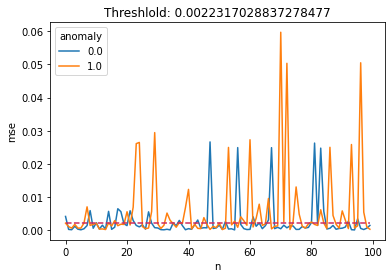

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

### version 3 more complexed architecture

In [15]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=64, activation='relu', input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=5, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=64, activation='relu', input_shape=[5]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 5)                 7173      
_________________________________________________________________
decoder (Sequential)         (None, 41)                7209      
Total params: 14,382
Trainable params: 14,382
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train, epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 41s 2ms/step - loss: 0.0153 - accuracy: 0.2176 - val_loss: 0.0075 - val_accuracy: 0.4464
Epoch 2/100
23066/23066 [==============================] - 41s 2ms/step - loss: 0.0068 - accuracy: 0.4535 - val_loss: 0.0058 - val_accuracy: 0.4845
Epoch 3/100
23066/23066 [==============================] - 44s 2ms/step - loss: 0.0056 - accuracy: 0.4768 - val_loss: 0.0053 - val_accuracy: 0.5146
Epoch 4/100
23066/23066 [==============================] - 40s 2ms/step - loss: 0.0050 - accuracy: 0.4880 - val_loss: 0.0048 - val_accuracy: 0.4756
Epoch 5/100
23066/23066 [==============================] - 44s 2ms/step - loss: 0.0048 - accuracy: 0.4674 - val_loss: 0.0046 - val_accuracy: 0.4824
Epoch 6/100
23066/23066 [==============================] - 40s 2ms/step - loss: 0.0045 - accuracy: 0.4679 - val_loss: 0.0043 - val_accuracy: 0.4718
Epoch 7/100
23066/23066 [==============================] - 40s 2ms/step - loss: 0.0042 - accuracy: 0.4673 - val_

In [18]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 21s 966us/step - loss: 0.0041 - accuracy: 0.4483


[0.004080663900822401, 0.4483242928981781]

In [19]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

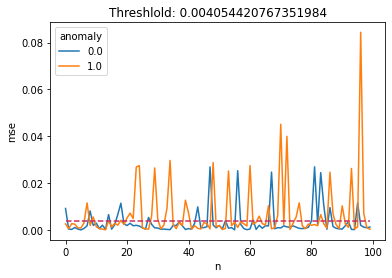

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

### Version 4 bottleneck from 8 5 to 8

In [25]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=64, activation='relu', input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=8, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[8]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                2688      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 264       
Total params: 5,032
Trainable params: 5,032
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                2112      
________________________________________

In [26]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 40s 2ms/step - loss: 0.0080 - accuracy: 0.3051 - val_loss: 0.0015 - val_accuracy: 0.3026
Epoch 2/100
23066/23066 [==============================] - 39s 2ms/step - loss: 0.0013 - accuracy: 0.2901 - val_loss: 0.0013 - val_accuracy: 0.3168
Epoch 3/100
23066/23066 [==============================] - 39s 2ms/step - loss: 0.0011 - accuracy: 0.3190 - val_loss: 0.0010 - val_accuracy: 0.3387
Epoch 4/100
23066/23066 [==============================] - 40s 2ms/step - loss: 0.0010 - accuracy: 0.3400 - val_loss: 9.9852e-04 - val_accuracy: 0.3179
Epoch 5/100
23066/23066 [==============================] - 39s 2ms/step - loss: 9.5604e-04 - accuracy: 0.3194 - val_loss: 8.0579e-04 - val_accuracy: 0.4167
Epoch 6/100
23066/23066 [==============================] - 43s 2ms/step - loss: 8.0515e-04 - accuracy: 0.3834 - val_loss: 8.5821e-04 - val_accuracy: 0.3940
Epoch 7/100
23066/23066 [==============================] - 39s 2ms/step - loss: 7.7789e-04 -

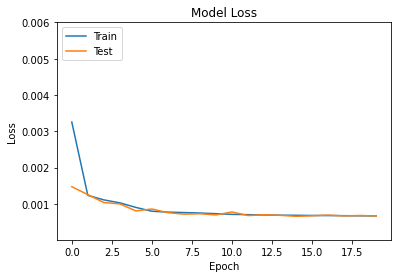

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [30]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 21s 945us/step - loss: 0.0021 - accuracy: 0.2792


[0.002147355815395713, 0.27921050786972046]

In [31]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

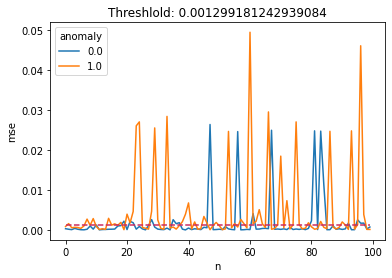

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

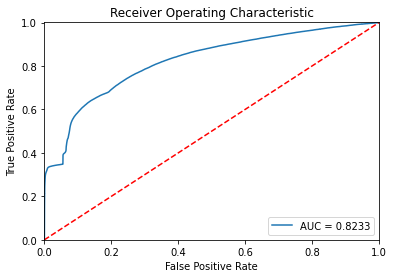

In [33]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

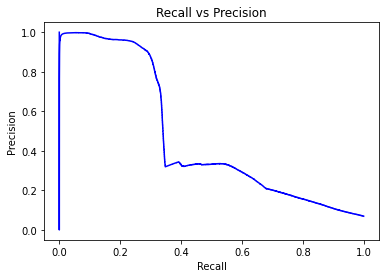

In [34]:
precision, recall, th = precision_recall_curve(error_df.loan_status, error_df.recon_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

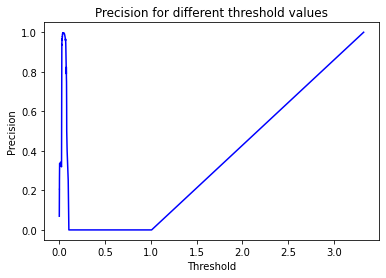

In [35]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

### version 5 more complexed architecure (best)

In [36]:
del autoencoder

In [38]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=128, activation='relu', input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=8, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[8]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 128)               5376      
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 264       
Total params: 15,976
Trainable params: 15,976
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 32)                288       
______________________________________

In [39]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 48s 2ms/step - loss: 0.0058 - accuracy: 0.3232 - val_loss: 8.9400e-04 - val_accuracy: 0.3233
Epoch 2/100
23066/23066 [==============================] - 51s 2ms/step - loss: 8.6556e-04 - accuracy: 0.3519 - val_loss: 7.4825e-04 - val_accuracy: 0.4085
Epoch 3/100
23066/23066 [==============================] - 48s 2ms/step - loss: 7.5372e-04 - accuracy: 0.3425 - val_loss: 5.9456e-04 - val_accuracy: 0.3123
Epoch 4/100
23066/23066 [==============================] - 48s 2ms/step - loss: 4.6382e-04 - accuracy: 0.3406 - val_loss: 3.9352e-04 - val_accuracy: 0.3798
Epoch 5/100
23066/23066 [==============================] - 49s 2ms/step - loss: 4.0437e-04 - accuracy: 0.3635 - val_loss: 6.0709e-04 - val_accuracy: 0.5129
Epoch 6/100
23066/23066 [==============================] - 48s 2ms/step - loss: 6.1339e-04 - accuracy: 0.4043 - val_loss: 6.8273e-04 - val_accuracy: 0.2081
Epoch 7/100
23066/23066 [==============================] - 49s 2ms/s

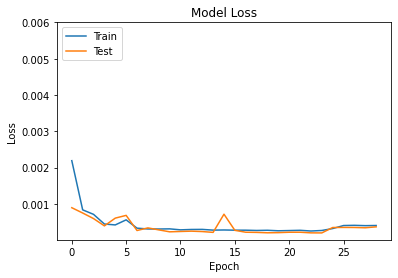

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [41]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 23s 1ms/step - loss: 8.7487e-04 - accuracy: 0.6988


[0.0008748658001422882, 0.6988389492034912]

In [42]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

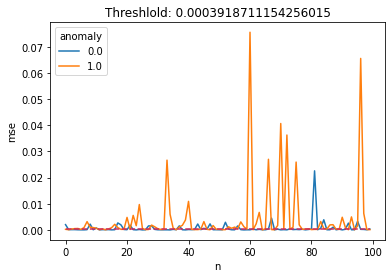

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

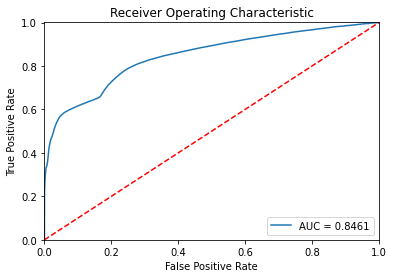

In [44]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Version 5.2 bottleneck from 8 to 10

In [18]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=128, activation='relu', input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=10, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[10]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               5376      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 16,042
Trainable params: 16,042
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                352       
______________________________________

In [19]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 46s 2ms/step - loss: 0.0066 - accuracy: 0.2118 - val_loss: 0.0013 - val_accuracy: 0.2035
Epoch 2/100
23066/23066 [==============================] - 46s 2ms/step - loss: 9.2400e-04 - accuracy: 0.2173 - val_loss: 7.1677e-04 - val_accuracy: 0.2666
Epoch 3/100
23066/23066 [==============================] - 47s 2ms/step - loss: 7.3940e-04 - accuracy: 0.2907 - val_loss: 5.7127e-04 - val_accuracy: 0.2929
Epoch 4/100
23066/23066 [==============================] - 46s 2ms/step - loss: 6.7060e-04 - accuracy: 0.3525 - val_loss: 3.5705e-04 - val_accuracy: 0.3086
Epoch 5/100
23066/23066 [==============================] - 48s 2ms/step - loss: 4.0294e-04 - accuracy: 0.3760 - val_loss: 3.3183e-04 - val_accuracy: 0.3935
Epoch 6/100
23066/23066 [==============================] - 47s 2ms/step - loss: 3.8801e-04 - accuracy: 0.3721 - val_loss: 6.3991e-04 - val_accuracy: 0.4356
Epoch 7/100
23066/23066 [==============================] - 46s 2ms/step 

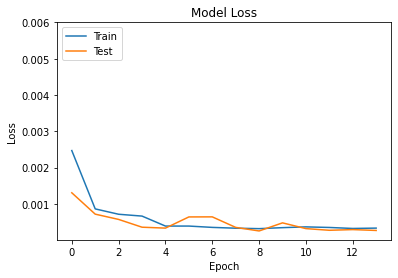

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [21]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 22s 992us/step - loss: 0.0017 - accuracy: 0.3831


[0.0016717456746846437, 0.3831353485584259]

In [22]:
autoencoder.evaluate(scaled_df_test,scaled_df_test)

23714/23714 [==============================] - 24s 1ms/step - loss: 0.0025 - accuracy: 0.3738


[0.0024652089923620224, 0.37381166219711304]

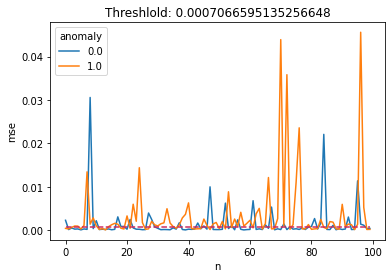

In [23]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

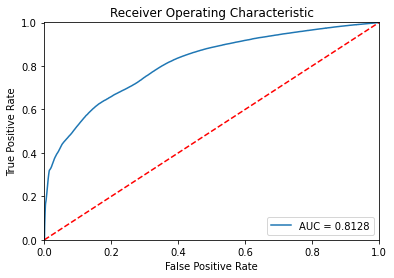

In [24]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### version 6 add more hidden layer

In [45]:
del autoencoder

In [46]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=256, activation='relu', input_shape=[n_features])) ##add
encoder.add(layer=layers.Dense(units=128, activation='relu'))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=8, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[8]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=256, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 256)               10752     
_________________________________________________________________
dense_53 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_54 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_55 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 264       
Total params: 54,248
Trainable params: 54,248
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [47]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 77s 3ms/step - loss: 0.0067 - accuracy: 0.2940 - val_loss: 0.0013 - val_accuracy: 0.3817
Epoch 2/100
23066/23066 [==============================] - 77s 3ms/step - loss: 0.0014 - accuracy: 0.3964 - val_loss: 9.7257e-04 - val_accuracy: 0.3620
Epoch 3/100
23066/23066 [==============================] - 75s 3ms/step - loss: 0.0012 - accuracy: 0.3569 - val_loss: 8.1983e-04 - val_accuracy: 0.3561
Epoch 4/100
23066/23066 [==============================] - 78s 3ms/step - loss: 9.8365e-04 - accuracy: 0.3532 - val_loss: 8.1899e-04 - val_accuracy: 0.3756
Epoch 5/100
23066/23066 [==============================] - 77s 3ms/step - loss: 9.5093e-04 - accuracy: 0.3733 - val_loss: 7.2494e-04 - val_accuracy: 0.3538
Epoch 6/100
23066/23066 [==============================] - 76s 3ms/step - loss: 8.5266e-04 - accuracy: 0.3542 - val_loss: 0.0034 - val_accuracy: 0.3484
Epoch 7/100
23066/23066 [==============================] - 75s 3ms/step - loss: 8.28

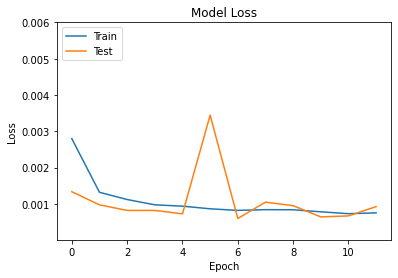

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [49]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 27s 1ms/step - loss: 0.0026 - accuracy: 0.2965


[0.002575894119217992, 0.2965027391910553]

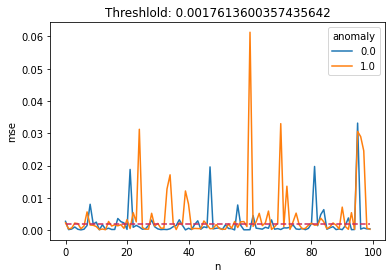

In [50]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

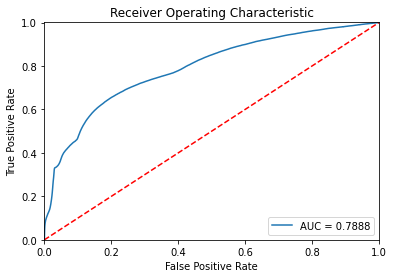

In [51]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### version 7 bottleneck from 8 to 10

In [ ]:
del autoencoder

In [15]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=256, activation='relu', input_shape=[n_features])) ##add
encoder.add(layer=layers.Dense(units=128, activation='relu'))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=10, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[10]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=256, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10752     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 54,314
Trainable params: 54,314
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [16]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 71s 3ms/step - loss: 0.0060 - accuracy: 0.2726 - val_loss: 5.9907e-04 - val_accuracy: 0.2773
Epoch 2/100
23066/23066 [==============================] - 63s 3ms/step - loss: 6.8375e-04 - accuracy: 0.2605 - val_loss: 0.0013 - val_accuracy: 0.2924
Epoch 3/100
23066/23066 [==============================] - 61s 3ms/step - loss: 6.3188e-04 - accuracy: 0.2565 - val_loss: 5.2803e-04 - val_accuracy: 0.3552
Epoch 4/100
23066/23066 [==============================] - 62s 3ms/step - loss: 5.2025e-04 - accuracy: 0.2608 - val_loss: 2.0292e-04 - val_accuracy: 0.1568
Epoch 5/100
23066/23066 [==============================] - 59s 3ms/step - loss: 3.1979e-04 - accuracy: 0.2289 - val_loss: 1.8426e-04 - val_accuracy: 0.3431
Epoch 6/100
23066/23066 [==============================] - 60s 3ms/step - loss: 2.8276e-04 - accuracy: 0.2864 - val_loss: 1.7555e-04 - val_accuracy: 0.3599
Epoch 7/100
23066/23066 [==============================] - 60s 3ms/step 

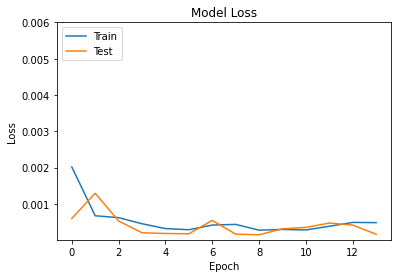

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [18]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 25s 1ms/step - loss: 0.0012 - accuracy: 0.3621


[0.001224759966135025, 0.36207541823387146]

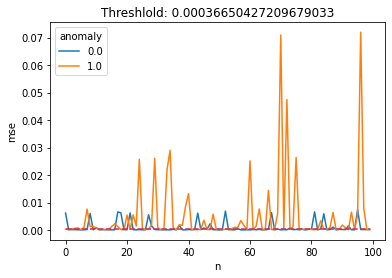

In [19]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

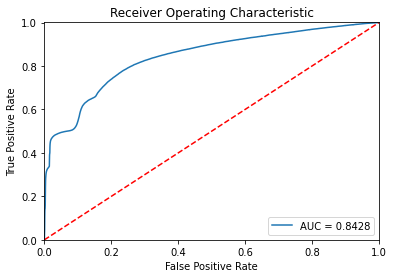

In [20]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Version 8 bottleneck from 10 to 12

In [25]:
del autoencoder

In [26]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=256, activation='relu', input_shape=[n_features])) ##add
encoder.add(layer=layers.Dense(units=128, activation='relu'))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=8, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[8]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=256, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               10752     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 12)                396       
Total params: 54,380
Trainable params: 54,380
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [27]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 68s 3ms/step - loss: 0.0077 - accuracy: 0.3409 - val_loss: 0.0012 - val_accuracy: 0.2712
Epoch 2/100
23066/23066 [==============================] - 73s 3ms/step - loss: 9.0076e-04 - accuracy: 0.2476 - val_loss: 7.2274e-04 - val_accuracy: 0.2116
Epoch 3/100
23066/23066 [==============================] - 71s 3ms/step - loss: 8.3015e-04 - accuracy: 0.2416 - val_loss: 4.6062e-04 - val_accuracy: 0.2294
Epoch 4/100
23066/23066 [==============================] - 71s 3ms/step - loss: 5.9005e-04 - accuracy: 0.2429 - val_loss: 4.1062e-04 - val_accuracy: 0.2410
Epoch 5/100
23066/23066 [==============================] - 72s 3ms/step - loss: 5.5912e-04 - accuracy: 0.2354 - val_loss: 4.4338e-04 - val_accuracy: 0.1864
Epoch 6/100
23066/23066 [==============================] - 71s 3ms/step - loss: 5.6753e-04 - accuracy: 0.2114 - val_loss: 3.8284e-04 - val_accuracy: 0.2584
Epoch 7/100
23066/23066 [==============================] - 72s 3ms/step 

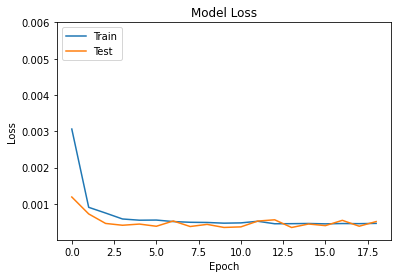

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [29]:
autoencoder.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 26s 1ms/step - loss: 0.0021 - accuracy: 0.3427


[0.002101515419781208, 0.34267064929008484]

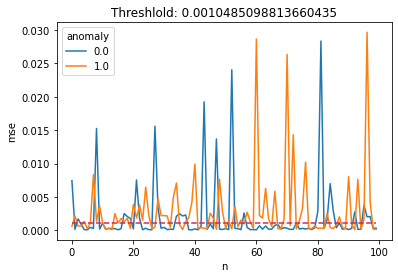

In [30]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = autoencoder.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

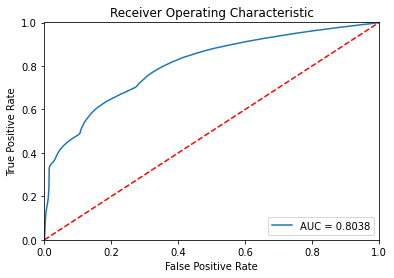

In [31]:
pred=autoencoder.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### version 9 very complexed model

In [25]:
del autoencoder

In [16]:
n_features = scaled_normal_train.shape[1]
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=128, activation='relu', input_shape=[n_features])) ##add
encoder.add(layer=layers.Dense(units=128, activation='relu'))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=64, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=32, activation='relu'))
encoder.add(layer=layers.Dense(units=16, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[16]))
decoder.add(layer=layers.Dense(units=32, activation='relu', input_shape=[16]))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=64, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=128, activation='relu'))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528 

In [17]:
# train model
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
autoencoder.compile(loss='MSE',optimizer='adam',metrics=['accuracy'])
history = autoencoder.fit(scaled_normal_train, scaled_normal_train,  epochs=100,  validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 70s 3ms/step - loss: 0.0098 - accuracy: 0.2844 - val_loss: 0.0018 - val_accuracy: 0.2716
Epoch 2/100
23066/23066 [==============================] - 68s 3ms/step - loss: 0.0017 - accuracy: 0.2369 - val_loss: 0.0025 - val_accuracy: 0.2224
Epoch 3/100
23066/23066 [==============================] - 68s 3ms/step - loss: 0.0016 - accuracy: 0.2469 - val_loss: 0.0027 - val_accuracy: 0.2411
Epoch 4/100
23066/23066 [==============================] - 66s 3ms/step - loss: 0.0014 - accuracy: 0.2891 - val_loss: 8.8314e-04 - val_accuracy: 0.3056
Epoch 5/100
23066/23066 [==============================] - 65s 3ms/step - loss: 0.0012 - accuracy: 0.2786 - val_loss: 8.7000e-04 - val_accuracy: 0.2656
Epoch 6/100
23066/23066 [==============================] - 66s 3ms/step - loss: 0.0012 - accuracy: 0.2801 - val_loss: 8.5480e-04 - val_accuracy: 0.2575
Epoch 7/100
23066/23066 [==============================] - 65s 3ms/step - loss: 0.0011 - accuracy: 0

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

## 2 Variational Auto-Encoder

### Version 1 intermediate_dim = 64

In [40]:
del vae

In [41]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [42]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [43]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 2948        input_4[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           2857        encoder[0][2]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 64)           2688        input_4[0][0]                    
____________________________________________________________________________________________

In [44]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 64)           2688        input_4[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 2)            130         dense_15[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2)            130         dense_15[0][0]                   
____________________________________________________________________________________________

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
history=vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100,
        batch_size=32,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 42s 2ms/step - loss: 12.2671 - accuracy: 0.1798 - val_loss: 11.1036 - val_accuracy: 0.3294
Epoch 2/100
23066/23066 [==============================] - 41s 2ms/step - loss: 11.0239 - accuracy: 0.3549 - val_loss: 10.9173 - val_accuracy: 0.3512
Epoch 3/100
23066/23066 [==============================] - 40s 2ms/step - loss: 10.8968 - accuracy: 0.3550 - val_loss: 10.8474 - val_accuracy: 0.3594
Epoch 4/100
23066/23066 [==============================] - 41s 2ms/step - loss: 10.8520 - accuracy: 0.3625 - val_loss: 10.8219 - val_accuracy: 0.3607
Epoch 5/100
23066/23066 [==============================] - 41s 2ms/step - loss: 10.8244 - accuracy: 0.3654 - val_loss: 10.8071 - val_accuracy: 0.3677
Epoch 6/100
23066/23066 [==============================] - 41s 2ms/step - loss: 10.8096 - accuracy: 0.3655 - val_loss: 10.7978 - val_accuracy: 0.3656
Epoch 7/100
23066/23066 [==============================] - 41s 2ms/step - loss: 10.7959 - accuracy: 

In [46]:
vae.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 23s 1ms/step - loss: 11.2612 - accuracy: 0.4023


[11.261165618896484, 0.4022795855998993]

In [47]:
vae.evaluate(scaled_df_test,scaled_df_test)

23714/23714 [==============================] - 27s 1ms/step - loss: 11.9176 - accuracy: 0.4002


[11.917551040649414, 0.4001784324645996]

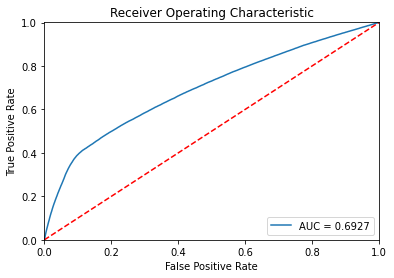

In [48]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

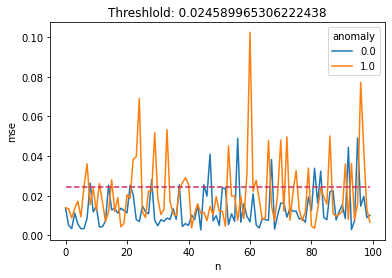

In [49]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

#### version 1.2 change optimizer from 'adam' to 'rmsprop'



In [17]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [18]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [19]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 2948        input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           2857        encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2688        input_1[0][0]                    
____________________________________________________________________________________________

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
history=vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100,
        batch_size=32,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 40s 2ms/step - loss: 12.2448 - accuracy: 0.1610 - val_loss: 11.1866 - val_accuracy: 0.2960
Epoch 2/100
23066/23066 [==============================] - 39s 2ms/step - loss: 11.1197 - accuracy: 0.3340 - val_loss: 11.0924 - val_accuracy: 0.3469
Epoch 3/100
23066/23066 [==============================] - 38s 2ms/step - loss: 39506896534.9570 - accuracy: 0.3264 - val_loss: 11.0928 - val_accuracy: 0.2918
Epoch 4/100
23066/23066 [==============================] - 38s 2ms/step - loss: nan - accuracy: 0.2019 - val_loss: nan - val_accuracy: 0.0401
Epoch 5/100
23066/23066 [==============================] - 38s 2ms/step - loss: nan - accuracy: 0.0413 - val_loss: nan - val_accuracy: 0.0401
Epoch 6/100
23066/23066 [==============================] - 38s 2ms/step - loss: nan - accuracy: 0.0411 - val_loss: nan - val_accuracy: 0.0401
Epoch 7/100
23066/23066 [==============================] - 38s 2ms/step - loss: nan - accuracy: 0.0413 - val_loss: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=0.006,ymin=0.00001)
plt.show()

In [ ]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

#### Version 1.3 change optimizer from 'adam' to 'adamax'

In [35]:
del vae

In [16]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [17]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [18]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adamax',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 2948        input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           2857        encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           2688        input_1[0][0]                    
____________________________________________________________________________________________

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss',  patience=5, restore_best_weights=True)
history=vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100,
        batch_size=32,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 36s 2ms/step - loss: 12.7699 - accuracy: 0.1258 - val_loss: 11.5040 - val_accuracy: 0.1994
Epoch 2/100
23066/23066 [==============================] - 34s 1ms/step - loss: 11.4498 - accuracy: 0.2140 - val_loss: 11.3184 - val_accuracy: 0.2182
Epoch 3/100
23066/23066 [==============================] - 34s 1ms/step - loss: 11.2810 - accuracy: 0.2193 - val_loss: 11.2513 - val_accuracy: 0.2137
Epoch 4/100
23066/23066 [==============================] - 36s 2ms/step - loss: 11.2265 - accuracy: 0.2141 - val_loss: 11.2039 - val_accuracy: 0.2088
Epoch 5/100
23066/23066 [==============================] - 35s 1ms/step - loss: 11.1885 - accuracy: 0.2076 - val_loss: 11.1758 - val_accuracy: 0.2032
Epoch 6/100
23066/23066 [==============================] - 34s 1ms/step - loss: 11.1605 - accuracy: 0.2040 - val_loss: 11.1489 - val_accuracy: 0.2060
Epoch 7/100
23066/23066 [==============================] - 34s 1ms/step - loss: 11.1280 - accuracy: 

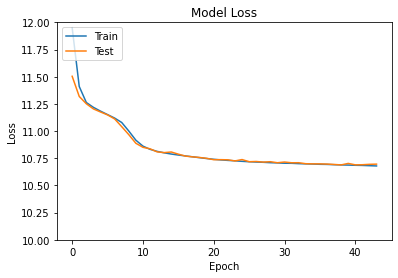

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(ymax=12,ymin=10)
plt.show()

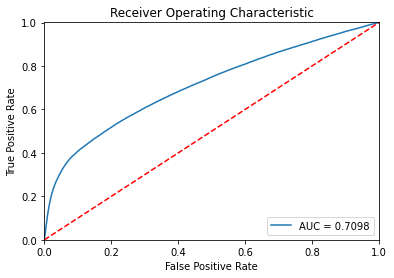

In [21]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

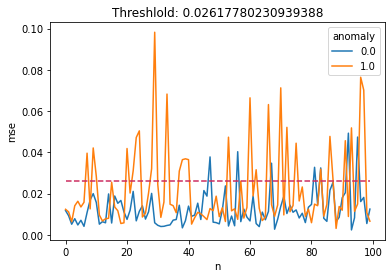

In [22]:
n_features = scaled_normal_train.shape[1]
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

### Version 2 intermediate_dim = 128

In [42]:
del vae

In [39]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
intermediate_dim = 128
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
#units: Positive integer, dimensionality of the output space.

In [43]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [44]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 5892        input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           5673        encoder[0][2]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 128)          5376        input_3[0][0]                    
____________________________________________________________________________________________

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, restore_best_weights=True)
vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100,
        batch_size=32,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
25629/25629 [==============================] - 53s 2ms/step - loss: 11.9504 - val_loss: 11.4625
Epoch 2/100
25629/25629 [==============================] - 52s 2ms/step - loss: 10.8816 - val_loss: 11.3607
Epoch 3/100
25629/25629 [==============================] - 51s 2ms/step - loss: 10.8248 - val_loss: 11.3669
Epoch 4/100
25629/25629 [==============================] - 52s 2ms/step - loss: 10.7796 - val_loss: 11.3336
Epoch 5/100
25629/25629 [==============================] - 51s 2ms/step - loss: 10.7238 - val_loss: 11.3315
Epoch 6/100
25629/25629 [==============================] - 51s 2ms/step - loss: 10.6883 - val_loss: 11.2329
Epoch 7/100
25629/25629 [==============================] - 53s 2ms/step - loss: 10.6748 - val_loss: 11.2786
Epoch 8/100
25629/25629 [==============================] - 51s 2ms/step - loss: 10.6562 - val_loss: 11.2452
Epoch 9/100
25629/25629 [==============================] - 52s 2ms/step - loss: 10.6417 - val_loss: 11.2482
Epoch 10/100
25629/25629 [==

In [121]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})

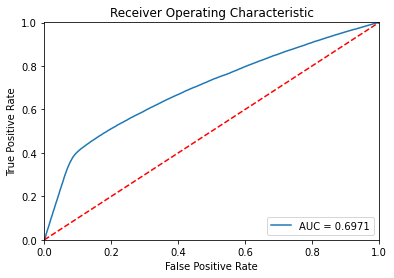

In [122]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

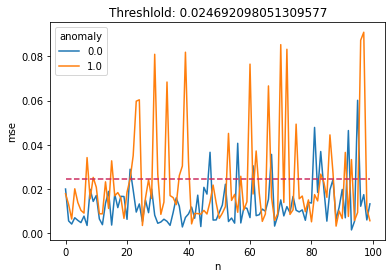

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

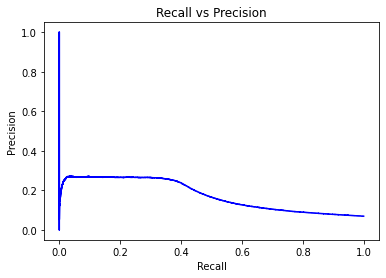

In [125]:
precision, recall, th = precision_recall_curve(error_df.loan_status, error_df.recon_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

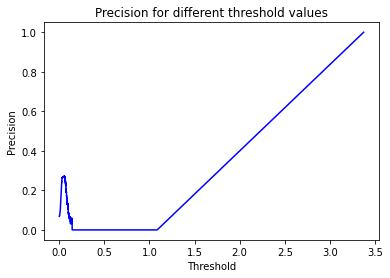

In [126]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

### Version 3 Add more hidden layers-max units=64

In [65]:
del vae

more complex model

In [66]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h1 = layers.Dense(intermediate_dim, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
h2=layers.Dense(32, activation='relu')(h1)
h3=layers.Dense(16, activation='relu')(h2)
z_mean = layers.Dense(latent_dim)(h3)
z_log_sigma = layers.Dense(latent_dim)(h3)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
#units: Positive integer, dimensionality of the output space.

In [67]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x1 = layers.Dense(16, activation='relu')(latent_inputs)
x2 = layers.Dense(32, activation='relu')(x1)
x3 = layers.Dense(intermediate_dim, activation='relu')(x2)
outputs = layers.Dense(original_dim, activation='sigmoid')(x3)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [68]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 5364        input_6[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           5369        encoder[0][2]                    
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 64)           2688        input_6[0][0]                    
____________________________________________________________________________________________

In [69]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 64)           2688        input_6[0][0]                    
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 32)           2080        dense_57[0][0]                   
__________________________________________________________________________________________________
dense_59 (Dense)                (None, 16)           528         dense_58[0][0]                   
____________________________________________________________________________________________

In [70]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_62 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_63 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_64 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_65 (Dense)             (None, 41)                2665      
Total params: 5,369
Trainable params: 5,369
Non-trainable params: 0
_________________________________________________________________


In [71]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100, batch_size=32,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
23066/23066 [==============================] - 66s 3ms/step - loss: 11.8518 - accuracy: 0.2591 - val_loss: 11.4920 - val_accuracy: 0.3612
Epoch 2/100
23066/23066 [==============================] - 64s 3ms/step - loss: 10.8738 - accuracy: 0.4114 - val_loss: 11.4076 - val_accuracy: 0.3651
Epoch 3/100
23066/23066 [==============================] - 64s 3ms/step - loss: 10.7912 - accuracy: 0.3908 - val_loss: 11.3829 - val_accuracy: 0.3536
Epoch 4/100
23066/23066 [==============================] - 64s 3ms/step - loss: 10.7411 - accuracy: 0.3804 - val_loss: 11.4048 - val_accuracy: 0.3445
Epoch 5/100
23066/23066 [==============================] - 67s 3ms/step - loss: 10.7157 - accuracy: 0.3840 - val_loss: 11.3348 - val_accuracy: 0.3779
Epoch 6/100
23066/23066 [==============================] - 65s 3ms/step - loss: 10.7040 - accuracy: 0.3839 - val_loss: 11.2588 - val_accuracy: 0.3810
Epoch 7/100
23066/23066 [==============================] - 65s 3ms/step - loss: 10.6861 - accuracy: 

In [72]:
vae.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 23s 1ms/step - loss: 11.2386 - accuracy: 0.3797


[11.238605499267578, 0.37972021102905273]

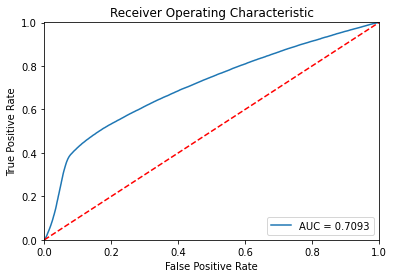

In [57]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

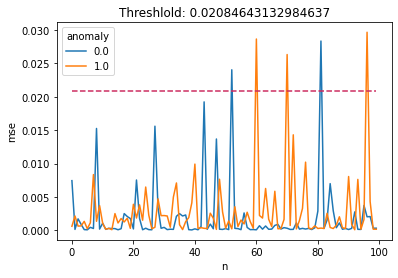

In [58]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

### Version 4 add more hidden layers max units=256

In [77]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h1 = layers.Dense(256, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
h2=layers.Dense(128, activation='relu')(h1)
h3=layers.Dense(64, activation='relu')(h2)
h4=layers.Dense(32, activation='relu')(h3)
h5=layers.Dense(16, activation='relu')(h4)
h6=layers.Dense(8, activation='relu')(h5)
z_mean = layers.Dense(latent_dim)(h6)
z_log_sigma = layers.Dense(latent_dim)(h6)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
#units: Positive integer, dimensionality of the output space.

In [78]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x1 = layers.Dense(8, activation='relu')(latent_inputs)
x2 = layers.Dense(16, activation='relu')(x1)
x3 = layers.Dense(32, activation='relu')(x2)
x4 = layers.Dense(64, activation='relu')(x3)
x5 = layers.Dense(128, activation='relu')(x4)
x6 = layers.Dense(256, activation='relu')(x5)
outputs = layers.Dense(original_dim, activation='sigmoid')(x6)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [80]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 256)          10752       input_7[0][0]                    
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 128)          32896       dense_66[0][0]                   
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 64)           8256        dense_67[0][0]                   
____________________________________________________________________________________________

In [79]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 54684       input_7[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           54705       encoder[0][2]                    
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 256)          10752       input_7[0][0]                    
____________________________________________________________________________________________

In [81]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100, batch_size=64,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
11533/11533 [==============================] - 76s 7ms/step - loss: 11.9020 - accuracy: 0.2243 - val_loss: 11.4113 - val_accuracy: 0.4220
Epoch 2/100
11533/11533 [==============================] - 76s 7ms/step - loss: 10.8148 - accuracy: 0.3595 - val_loss: 11.3219 - val_accuracy: 0.4163
Epoch 3/100
11533/11533 [==============================] - 74s 6ms/step - loss: 10.7165 - accuracy: 0.3624 - val_loss: 11.3047 - val_accuracy: 0.3813
Epoch 4/100
11533/11533 [==============================] - 76s 7ms/step - loss: 10.6613 - accuracy: 0.3357 - val_loss: 11.2554 - val_accuracy: 0.3419
Epoch 5/100
11533/11533 [==============================] - 75s 7ms/step - loss: 10.6365 - accuracy: 0.3250 - val_loss: 11.2622 - val_accuracy: 0.3710
Epoch 6/100
11533/11533 [==============================] - 75s 7ms/step - loss: 10.6128 - accuracy: 0.3241 - val_loss: 11.2300 - val_accuracy: 0.3535
Epoch 7/100
11533/11533 [==============================] - 77s 7ms/step - loss: 10.6005 - accuracy: 

In [82]:
vae.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 31s 1ms/step - loss: 11.1716 - accuracy: 0.3450


[11.171555519104004, 0.34501537680625916]

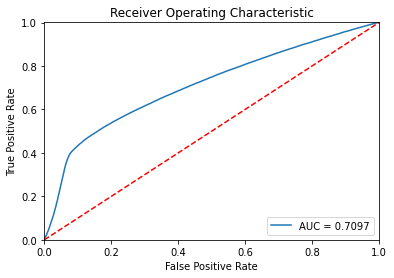

In [83]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

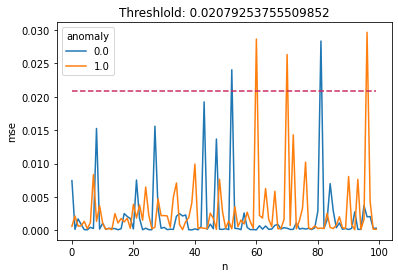

In [84]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

### Version 5 more complex 512

In [105]:
del vae

In [106]:
import keras
from keras import layers

original_dim = scaled_normal_train.shape[1]
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h1 = layers.Dense(512, activation='relu')(inputs)  #h value would be 64 different information from 64 neurons #hidden layer
h2=layers.Dense(256, activation='relu')(h1)
h3=layers.Dense(128, activation='relu')(h2)
h4=layers.Dense(128, activation='relu')(h3)
h5=layers.Dense(64, activation='relu')(h4)
h6=layers.Dense(64, activation='relu')(h5)
h7=layers.Dense(32, activation='relu')(h6)
h8=layers.Dense(32, activation='relu')(h7)
h9=layers.Dense(32, activation='relu')(h8)

z_mean = layers.Dense(latent_dim)(h9)
z_log_sigma = layers.Dense(latent_dim)(h9)

from keras import backend as K
#sample function
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
#units: Positive integer, dimensionality of the output space.

In [107]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder') #Model class Arguments: inputs; outputs; name

# Create decoder
# using latent inputs to define the X(the value from latent distribution), then we can get all the outputs for the image.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x1 = layers.Dense(32, activation='relu')(latent_inputs)
x2 = layers.Dense(32, activation='relu')(x1)
x3 = layers.Dense(32, activation='relu')(x2)
x4 = layers.Dense(64, activation='relu')(x3)
x5 = layers.Dense(64, activation='relu')(x4)
x6 = layers.Dense(128, activation='relu')(x5)
x7 = layers.Dense(128, activation='relu')(x6)
x8 = layers.Dense(256, activation='relu')(x7)
x9 = layers.Dense(512, activation='relu')(x8)
outputs = layers.Dense(original_dim, activation='sigmoid')(x9)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [108]:
#loss function 1)reconstruction; 2)kl_loss
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 218980      input_11[0][0]                   
__________________________________________________________________________________________________
decoder (Functional)            (None, 41)           218953      encoder[0][2]                    
__________________________________________________________________________________________________
dense_142 (Dense)               (None, 512)          21504       input_11[0][0]                   
____________________________________________________________________________________________

In [109]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_142 (Dense)               (None, 512)          21504       input_11[0][0]                   
__________________________________________________________________________________________________
dense_143 (Dense)               (None, 256)          131328      dense_142[0][0]                  
__________________________________________________________________________________________________
dense_144 (Dense)               (None, 128)          32896       dense_143[0][0]                  
____________________________________________________________________________________________

In [110]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = vae.fit(x=scaled_normal_train, y=scaled_normal_train,
        epochs=100, batch_size=256,
        validation_data=(scaled_normal_validation, scaled_normal_validation), callbacks=[es])

Epoch 1/100
2884/2884 [==============================] - 91s 31ms/step - loss: 12.6211 - accuracy: 0.1381 - val_loss: 10.8823 - val_accuracy: 0.3094
Epoch 2/100
2884/2884 [==============================] - 89s 31ms/step - loss: 10.8260 - accuracy: 0.2636 - val_loss: 10.7268 - val_accuracy: 0.2925
Epoch 3/100
2884/2884 [==============================] - 89s 31ms/step - loss: 10.7144 - accuracy: 0.2996 - val_loss: 10.7060 - val_accuracy: 0.3097
Epoch 4/100
2884/2884 [==============================] - 89s 31ms/step - loss: 10.6479 - accuracy: 0.3078 - val_loss: 10.6576 - val_accuracy: 0.2970
Epoch 5/100
2884/2884 [==============================] - 90s 31ms/step - loss: 10.6196 - accuracy: 0.2907 - val_loss: 10.6234 - val_accuracy: 0.2810
Epoch 6/100
2884/2884 [==============================] - 89s 31ms/step - loss: 10.5949 - accuracy: 0.2593 - val_loss: 10.5912 - val_accuracy: 0.2597
Epoch 7/100
2884/2884 [==============================] - 90s 31ms/step - loss: 10.5768 - accuracy: 0.2399 

In [111]:
vae.evaluate(scaled_normal_test,scaled_normal_test)

22071/22071 [==============================] - 62s 3ms/step - loss: 11.0932 - accuracy: 0.1573


[11.09317684173584, 0.15731094777584076]

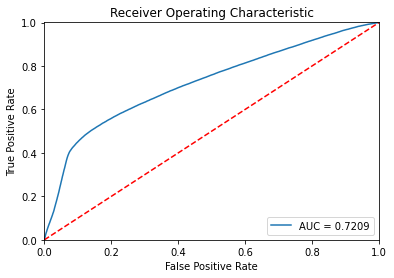

In [112]:
pred=vae.predict(scaled_df_test)
mse = np.mean(np.power(scaled_df_test - pred, 2), axis=1)
y_test=df_test['loan_status']
error_df = pd.DataFrame({'recon_error': mse,
                        'loan_status': y_test})
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.loan_status, error_df.recon_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

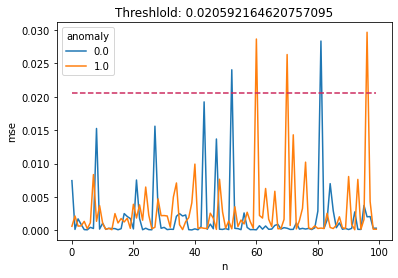

In [113]:
#threshold
#We will consider a transaction as an anomaly if the mse is higher than threshold
from tensorflow import keras
train_predicted_x = vae.predict(x=scaled_normal_train)
train_events_mse = keras.losses.mean_squared_error(scaled_normal_train, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
plot_samples = 100
# normal event
real_x = scaled_normal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=real_x)
normal_events_mse = keras.losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaled_abnormal_test[:plot_samples].reshape(plot_samples, n_features)
predicted_x = vae.predict(x=abnormal_x)
abnormal_events_mse = keras.losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

## Conlusion

Through changing architecture, parameters, and early stopping, autoencoder can be improved, but VAE just has similar result. Overall, currently, autoencoder performs better than the VAE, and version 5 of autoencoder can have best result.